In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import distinct

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# Reflect an existing database into a new model
Base = automap_base()

# Reflect the tables
Base.prepare(engine, reflect=True)


In [7]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date


('2017-08-23',)

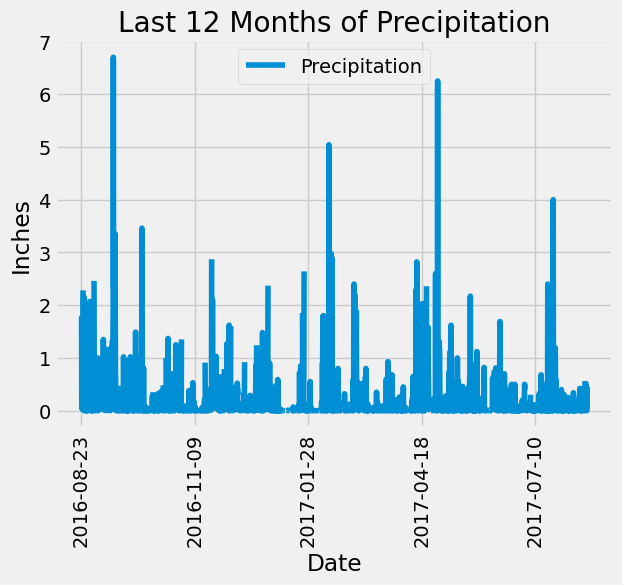

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date_query = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date = pd.to_datetime(most_recent_date_query[0])

# Calculate the date one year from the last date in data set.
start_date = most_recent_date - pd.DateOffset(years=1)

# converting timestamp tuple to string for sqlalchemy
start_date_string = start_date.strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
query_results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= start_date_string).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(query_results, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x='Date', y='Precipitation', title='Last 12 Months of Precipitation')
plt.xlabel('Date')
plt.xticks(rotation=90) 
plt.ylabel('Inches')
plt.legend(['Precipitation'])
plt.show()



In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = precipitation_df['Precipitation'].describe()
summary_statistics


count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(distinct(Station.station))).scalar()
total_stations


9

In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

most_active_stations = (session.query(Measurement.station, func.count(Measurement.station))
                        .group_by(Measurement.station)
                        .order_by(func.count(Measurement.station).desc())
                        .all())

for station, count in most_active_stations:
    print(f"Station: {station}, Count: {count}")

most_active_station_id = most_active_stations[0][0]

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temperature_stats = (session.query(func.min(Measurement.tobs),
                                   func.max(Measurement.tobs),
                                   func.avg(Measurement.tobs))
                     .filter(Measurement.station == most_active_station_id)
                     .all())
temperature_stats

[(54.0, 85.0, 71.66378066378067)]

The most active station ID is:USC00519281


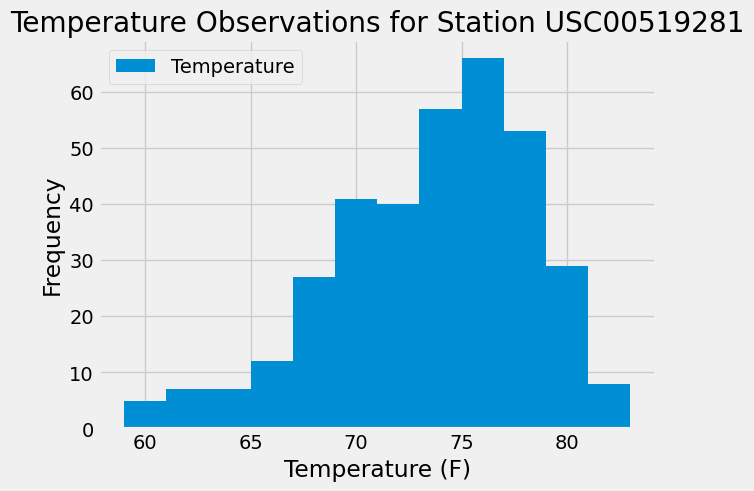

In [21]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Get the most active station ID
print(f'The most active station ID is:{most_active_station_id}')

# Query the last 12 months of temperature observation data
temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= start_date_string).all()

# Convert to DataFrame
temperature_df = pd.DataFrame(temperature_data, columns=['Temperature'])

# Plot the histogram
temperature_df.plot.hist(bins=12)
plt.title('Temperature Observations for Station ' + most_active_station_id)
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.show()



# Close Session

In [ ]:
# Close Session
session.close()